# **Summary: The script is devoted to Outline and Skeleton creation and Motion Detection.**

# **Mount your drive**

In [ ]:
# mount drive to work with google drive
from google.colab import drive
import os
drive.mount('/content/drive/', force_remount=True)
%cd /content
os.chdir('/content/drive/MyDrive/AAAI/') #path was adjusted manually

Mounted at /content/drive/
/content


## **Install Libraries**

In [ ]:
!pip install notebook==6.5.5
!pip install imageio opencv-python numpy pillow matplotlib scikit-image ipyvolume itkwidgets SimpleITK wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## **Import Libraries**

In [ ]:
import os
import sys
import cv2
import numpy as np
import imageio
import matplotlib.pyplot as plt
from PIL import Image, ImageSequence
from IPython.display import display, Image as IPImage
from google.colab import files
from google.colab.patches import cv2_imshow
from skimage import morphology, color, img_as_ubyte, io
from skimage.morphology import skeletonize
import SimpleITK as sitk
import nibabel as nib
import ipyvolume as ipv
import itkwidgets as itk
import csv

# **File upload - UPLOAD YOUR FILE HERE**

Saving download (3).gif to download (3).gif
download (3).gif


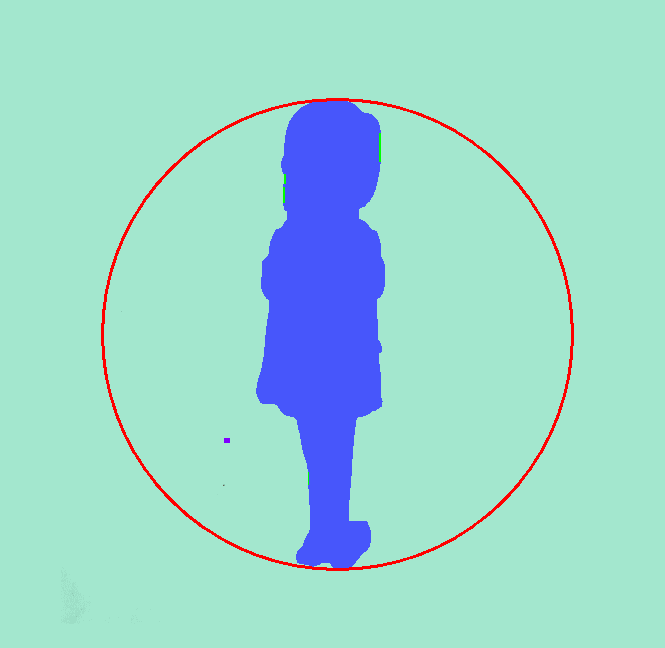

Number of frames in the GIF: 24


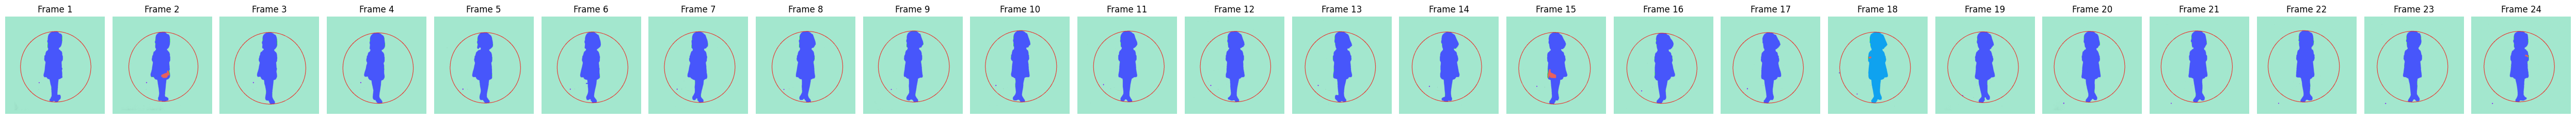

/content/drive/MyDrive/AAAI/original_download (3)
/content/drive/MyDrive/AAAI/download (3).gif


In [18]:
# Prompt user to upload GIF file
uploaded = files.upload()

# Get the name of the uploaded file
input_gif_name = list(uploaded.keys())[0]
print(input_gif_name)

# Ensure the file is saved in the specified directory
SAVE_DIRECTORY = "/content/drive/MyDrive/AAAI/"
save_path = os.path.join(SAVE_DIRECTORY, input_gif_name)
with open(save_path, 'wb') as f:
    f.write(uploaded[input_gif_name])

# Display the uploaded GIF
with open(save_path, "rb") as f:
    display(IPImage(data=f.read(), format='png'))

# Extract frames from the GIF
img = Image.open(save_path)
frames = [frame.copy() for frame in ImageSequence.Iterator(img)]
print(f"Number of frames in the GIF: {len(frames)}")

# Derive a directory to save the extracted frames
frame_save_directory = os.path.join(SAVE_DIRECTORY, "original_" + os.path.splitext(input_gif_name)[0])
if not os.path.exists(frame_save_directory):
    os.makedirs(frame_save_directory)

# Save frames
saved_paths = []
for idx, frame in enumerate(frames):
    frame_save_path = os.path.join(frame_save_directory, f"frame_{idx + 1}.png")
    frame.save(frame_save_path)
    saved_paths.append(frame_save_path)

# Display the saved frames
fig, axes = plt.subplots(1, len(frames), figsize=(50, 30))
for i, ax in enumerate(axes):
    ax.imshow(plt.imread(saved_paths[i]))
    ax.set_title(f"Frame {i + 1}")
    ax.axis('off')
plt.tight_layout()
plt.show()
print(frame_save_directory)
print(save_path)

## **Functions**

Without approximation

In [10]:
def make_skeleton_thicker(skeleton, thickness=3):
    kernel = np.ones((thickness, thickness), np.uint8)
    thick_skeleton = cv2.dilate(skeleton, kernel, iterations=1)
    return thick_skeleton

def process_gif(gif_path, save_directory, use_approximation=False, combine_skeleton=False):
    frames = [frame for frame in imageio.get_reader(gif_path)]
    max_width = max([frame.shape[1] for frame in frames])
    max_height = max([frame.shape[0] for frame in frames])

    outlines = []
    skeletons = []
    motion_detected_frames = []
    background_model = cv2.cvtColor(frames[0], cv2.COLOR_RGBA2GRAY)

    for frame in frames:
        if frame.shape[-1] == 4:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGBA2RGB)

        delta_w = max_width - frame.shape[1]
        delta_h = max_height - frame.shape[0]
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)
        frame = cv2.copyMakeBorder(frame, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blurred, 50, 150)
        kernel = np.ones((5, 5), np.uint8)
        dilated = cv2.dilate(edges, kernel, iterations=2)
        eroded = cv2.erode(dilated, kernel, iterations=2)

        contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        outline = np.zeros_like(frame)

        if use_approximation:
            for contour in contours:
                epsilon = 0.01 * cv2.arcLength(contour, True)
                approx = cv2.approxPolyDP(contour, epsilon, True)
                cv2.drawContours(outline, [approx], -1, (0, 255, 255), 2)
        else:
            cv2.drawContours(outline, contours, -1, (0, 255, 0), 2)

        if combine_skeleton:
            skeleton = morphology.skeletonize(eroded // 255).astype(np.uint8) * 255
            thick_skeleton = make_skeleton_thicker(skeleton, thickness=3)
            outline[thick_skeleton == 255] = [255, 255, 0]  # Yellow color for skeleton
            skeletons.append(thick_skeleton)

        outlines.append(outline)

        # Motion Detection
        diff = cv2.absdiff(gray, background_model)
        _, thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        thresh = cv2.dilate(thresh, kernel, iterations=2)
        thresh = cv2.erode(thresh, kernel, iterations=1)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        motion_frame = frame.copy()
        for contour in contours:
            if cv2.contourArea(contour) > 500:
                (x, y, w, h) = cv2.boundingRect(contour)
                cv2.rectangle(motion_frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        motion_detected_frames.append(motion_frame)

    if use_approximation:
        outline_save_path = os.path.join(save_directory, 'outlined_objects_approx.gif')
    else:
        outline_save_path = os.path.join(save_directory, 'outlined_objects.gif')
    imageio.mimsave(outline_save_path, outlines, duration=0.1)

    skeleton_save_path = os.path.join(save_directory, 'skeletons.gif')
    imageio.mimsave(skeleton_save_path, skeletons, duration=0.1)

    motion_save_path = os.path.join(save_directory, 'motion_detected.gif')
    imageio.mimsave(motion_save_path, motion_detected_frames, duration=0.1)

    return outline_save_path, skeleton_save_path, motion_save_path

# Call the function with the appropriate parameters
outline_save_path, skeleton_save_path, motion_save_path = process_gif(save_path, SAVE_DIRECTORY, use_approximation=False, combine_skeleton=True)

# Display the results
IPImage(filename=outline_save_path), IPImage(filename=skeleton_save_path), IPImage(filename=motion_save_path)


(<IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>)

## **Create Countours**

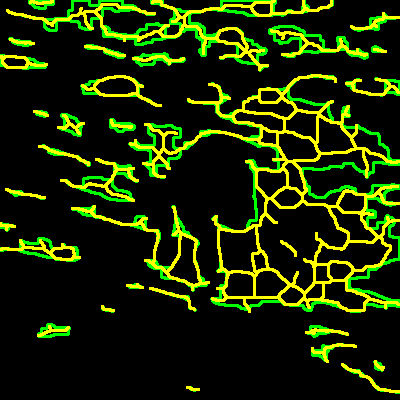

In [11]:
# Display the modified outlined GIF
IPImage(filename=outline_save_path)

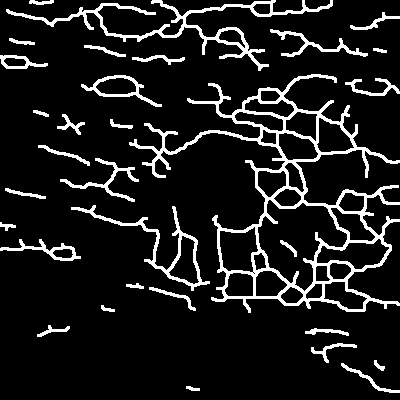

In [12]:
# Display the modified outlined GIF
IPImage(filename=skeleton_save_path)

In [13]:
# Display the modified outlined GIF
IPImage(filename=motion_save_path)

Output hidden; open in https://colab.research.google.com to view.

In [14]:
def process_gif(gif_path, save_directory, use_approximation=False, combine_skeleton=False):
    frames = [frame for frame in imageio.get_reader(gif_path)]
    max_width = max([frame.shape[1] for frame in frames])
    max_height = max([frame.shape[0] for frame in frames])
    outlines = []
    skeletons = []
    motion_detected_frames = []
    background_model = cv2.cvtColor(frames[0], cv2.COLOR_RGBA2GRAY)

    for frame in frames:
        if frame.shape[-1] == 4:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGBA2RGB)

        delta_w = max_width - frame.shape[1]
        delta_h = max_height - frame.shape[0]
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)
        frame = cv2.copyMakeBorder(frame, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blurred, 50, 150)
        kernel = np.ones((5, 5), np.uint8)
        dilated = cv2.dilate(edges, kernel, iterations=2)
        eroded = cv2.erode(dilated, kernel, iterations=2)

        contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        outline = np.zeros_like(frame)

        if use_approximation:
            for contour in contours:
                epsilon = 0.01 * cv2.arcLength(contour, True)
                approx = cv2.approxPolyDP(contour, epsilon, True)
                cv2.drawContours(outline, [approx], -1, (0, 255, 255), 2)
        else:
            cv2.drawContours(outline, contours, -1, (0, 255, 0), 2)

        if combine_skeleton:
            skeleton = morphology.skeletonize(eroded // 255).astype(np.uint8) * 255
            thick_skeleton = make_skeleton_thicker(skeleton, thickness=3)
            outline[thick_skeleton == 255] = [255, 255, 0]  # Yellow color for skeleton
            skeletons.append(thick_skeleton)

        outlines.append(outline)

        # Motion Detection
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        diff = cv2.absdiff(gray, background_model)
        _, thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        thresh = cv2.dilate(thresh, kernel, iterations=2)
        thresh = cv2.erode(thresh, kernel, iterations=1)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        motion_frame = frame.copy()
        for contour in contours:
            if cv2.contourArea(contour) > 500:
                (x, y), radius = cv2.minEnclosingCircle(contour)
                cv2.circle(motion_frame, (int(x), int(y)), int(radius), (0, 255, 0), 2)
        motion_detected_frames.append(motion_frame)

    if use_approximation:
        outline_save_path = os.path.join(save_directory, 'outlined_objects_approx.gif')
    else:
        outline_save_path = os.path.join(save_directory, 'outlined_objects.gif')
    imageio.mimsave(outline_save_path, outlines, duration=0.1)

    skeleton_save_path = os.path.join(save_directory, 'skeletons.gif')
    imageio.mimsave(skeleton_save_path, skeletons, duration=0.1)

    motion_save_path = os.path.join(save_directory, 'motion_detected.gif')
    imageio.mimsave(motion_save_path, motion_detected_frames, duration=0.1)

    return outline_save_path, skeleton_save_path, motion_save_path

# Display the results
IPImage(filename=outline_save_path), IPImage(filename=skeleton_save_path), IPImage(filename=motion_save_path)


(<IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>)

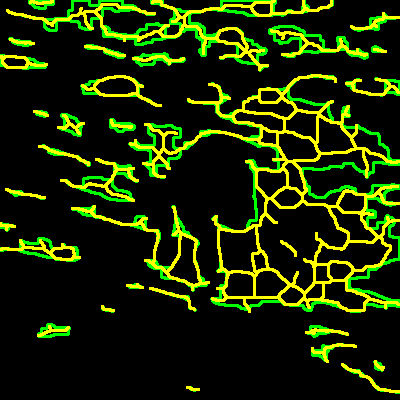

In [15]:
# Display the modified outlined GIF
IPImage(filename=outline_save_path)

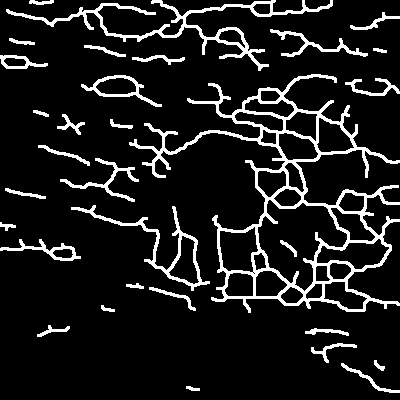

In [16]:
# Display the modified outlined GIF
IPImage(filename=skeleton_save_path)

In [17]:
# Display the modified outlined GIF
IPImage(filename=motion_save_path)

Output hidden; open in https://colab.research.google.com to view.

## **This is an older stuff**

In [ ]:
# Read the GIF file
frames = [frame for frame in imageio.get_reader(save_path)]

# Determine the maximum width and height across all frames
max_width = max([frame.shape[1] for frame in frames])
max_height = max([frame.shape[0] for frame in frames])

# Process each frame
outlines = []
for frame in frames:
    # Resize the frame with padding
    delta_w = max_width - frame.shape[1]
    delta_h = max_height - frame.shape[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    frame = cv2.copyMakeBorder(frame, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred, 50, 150)

    # Apply Morphological Operations
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)
    eroded = cv2.erode(dilated, kernel, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours
    outline = cv2.drawContours(frame.copy(), contours, -1, (0, 255, 0), 2)

    # Ensure the outline has only 3 channels (RGB)
    outline = outline[:, :, :3]

    outlines.append(outline)

# Save the frames with outlines as a new GIF
outline_save_directory2 =  os.path.join(SAVE_DIRECTORY, 'outlined_objects2.gif')
imageio.mimsave(outline_save_directory2, outlines, duration=0.1)

# Display the outlined GIF
IPImage(filename=outline_save_directory2)

## **Contour Approximation**

In [ ]:
# Read the GIF file
frames = [frame for frame in imageio.get_reader(save_path)]

# Determine the maximum width and height across all frames
max_width = max([frame.shape[1] for frame in frames])
max_height = max([frame.shape[0] for frame in frames])

# Process each frame
outlines = []
for i, frame in enumerate(frames):
    # Convert to RGB if not already
    if frame.shape[-1] == 4:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGBA2RGB)

    # Resize the frame with padding
    delta_w = max_width - frame.shape[1]
    delta_h = max_height - frame.shape[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    frame = cv2.copyMakeBorder(frame, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred, 50, 150)

    # Apply Morphological Operations
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)
    eroded = cv2.erode(dilated, kernel, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize a blank canvas for drawing contours
    outline = np.zeros_like(frame)

    # Apply Contour Approximation and Draw Contours
    for contour in contours:
        epsilon = 0.01 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        cv2.drawContours(outline, [approx], -1, (0, 255, 255), 2)  # Yellow color for contours

    outlines.append(outline)

    # Check and print the shape of each frame
    #print(f"Frame {i}: {outline.shape}")

# Check if all frames have the same shape
unique_shapes = set(frame.shape for frame in outlines)
if len(unique_shapes) != 1:
    raise ValueError("Not all frames have the same shape, please check the input frames and processing steps.")

# Save the frames with outlines as a new GIF
outline_save_directory = os.path.join(SAVE_DIRECTORY, 'outlined_objects.gif')
imageio.mimsave(outline_save_directory, outlines, duration=0.1)

# Display the outlined GIF
IPImage(filename=outline_save_directory)


## **No Contour Approximation**

In [ ]:
# Read the GIF file
frames = [frame for frame in imageio.get_reader(save_path)]

# Determine the maximum width and height across all frames
max_width = max([frame.shape[1] for frame in frames])
max_height = max([frame.shape[0] for frame in frames])

# Process each frame
outlines = []
for frame in frames:
    # Resize the frame with padding
    delta_w = max_width - frame.shape[1]
    delta_h = max_height - frame.shape[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    frame = cv2.copyMakeBorder(frame, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred, 50, 150)

    # Apply Morphological Operations
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)
    eroded = cv2.erode(dilated, kernel, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank canvas
    blank_canvas = np.zeros_like(frame)

    # Draw contours on the blank canvas
    outline = cv2.drawContours(blank_canvas, contours, -1, (0, 255, 255), 2)  # Yellow color

    # Ensure the outline has only 3 channels (RGB)
    outline = outline[:, :, :3]

    outlines.append(outline)

# Save the frames with outlines as a new GIF
outline_save_directory = os.path.join(SAVE_DIRECTORY, 'outlined_objects_yellow.gif')
imageio.mimsave(outline_save_directory, outlines, duration=0.1, format='GIF')

# Display the outlined GIF
with open(outline_save_directory, "rb") as f:
    display(IPImage(data=f.read(), format="png"))


# **Cheetah in the Circle - Refine the contours to minimize noise**

In [ ]:
import cv2
import numpy as np
import imageio
from IPython.display import Image as IPImage
import os

def bresenham_line(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    sx = -1 if x0 > x1 else 1
    sy = -1 if y0 > y1 else 1
    if dx > dy:
        err = dx / 2.0
        while x != x1:
            points.append((x, y))
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2.0
        while y != y1:
            points.append((x, y))
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy
    points.append((x, y))
    return points

def draw_line(img, x0, y0, x1, y1, color):
    for x, y in bresenham_line(x0, y0, x1, y1):
        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
            if np.any(img[int(y), int(x)] != [255, 255, 255]):  # Stop if not background color
                break
            img[int(y), int(x)] = color

gif = imageio.mimread(outline_save_directory)

processed_frames = []

# Process each frame in the GIF
for frame in gif:
    # Convert the frame from imageio format to OpenCV format
    image = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Thresholding
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out small contours based on a threshold
    area_threshold = 500  # Set your threshold here
    large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > area_threshold]

    # Draw enclosing circles and lines for each large contour
    for contour in large_contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        cv2.circle(image, (int(x), int(y)), int(radius), (255, 0, 0), 2)
        for i in range(0, len(contour), 10):
            px, py = contour[i][0]
            draw_line(image, int(x), int(y), px, py, (0, 255, 0))

    # Convert the processed frame back to imageio format
    processed_frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)
    processed_frames.append(processed_frame)

# Save the modified image
modified_outlined_objects_path = os.path.join(SAVE_DIRECTORY, 'modified_outlined_objects.gif')
imageio.mimsave(modified_outlined_objects_path, processed_frames, duration=0.1)

# Display the modified outlined GIF
IPImage(filename=modified_outlined_objects_path)

In [ ]:
import cv2
import numpy as np
import imageio
from IPython.display import Image as IPImage
import os

def bresenham_line(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    sx = -1 if x0 > x1 else 1
    sy = -1 if y0 > y1 else 1
    if dx > dy:
        err = dx / 2.0
        while x != x1:
            points.append((x, y))
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2.0
        while y != y1:
            points.append((x, y))
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy
    points.append((x, y))
    return points

def draw_line(img, x0, y0, x1, y1, color):
    for x, y in bresenham_line(x0, y0, x1, y1):
        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
            if np.any(img[int(y), int(x)] != [255, 255, 255]):  # Stop if not background color
                break
            img[int(y), int(x)] = color

gif = imageio.mimread(outline_save_directory)

processed_frames = []

# Process each frame in the GIF
for frame in gif:
    # Convert the frame from imageio format to OpenCV format
    image = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Thresholding
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out small contours based on a threshold
    area_threshold = 500  # Set your threshold here
    large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > area_threshold]

    # Draw enclosing circles and lines for each large contour
    for contour in large_contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        cv2.circle(image, (int(x), int(y)), int(radius), (255, 0, 0), 2)
        for i in range(0, len(contour), 10):
            px, py = contour[i][0]
            draw_line(image, int(x), int(y), px, py, (0, 255, 0))

    # Convert the processed frame back to imageio format
    processed_frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)
    processed_frames.append(processed_frame)

# Save the modified image
modified_outlined_objects_path = os.path.join(SAVE_DIRECTORY, 'modified_outlined_objects2.gif')
imageio.mimsave(modified_outlined_objects_path, processed_frames, duration=0.1)

# Display the modified outlined GIF
IPImage(filename=modified_outlined_objects_path)

In [ ]:
# Read the outlined GIF file
outlined_frames = [frame for frame in imageio.get_reader(outline_save_directory)]

# Process each outlined frame to focus on larger objects
processed_frames = []
for frame in outlined_frames:
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Threshold the image
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If there are no contours, continue to the next frame
    if not contours:
        processed_frames.append(frame)
        continue

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Calculate the area of the largest contour
    max_area = cv2.contourArea(largest_contour)

    # Filter out contours that are much smaller than the largest contour
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 0.1 * max_area]  # Adjust the threshold as needed

    # Draw the filtered contours
    processed_frame = cv2.drawContours(frame.copy(), filtered_contours, -1, (0, 255, 0), 2)

    processed_frames.append(processed_frame)

# Save the frames with processed outlines as a new GIF
processed_outline_save_directory = os.path.join(SAVE_DIRECTORY, 'processed_outlined_objects.gif')
imageio.mimsave(processed_outline_save_directory, processed_frames, duration=0.1)

# Display the processed outlined GIF
IPImage(filename=processed_outline_save_directory)

In [ ]:
# Read the outlined GIF file
outlined_frames = [frame for frame in imageio.get_reader(outline_save_directory)]

# Process each outlined frame to focus on larger objects
processed_frames = []
for frame in outlined_frames:
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Threshold the image
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If there are no contours, continue to the next frame
    if not contours:
        processed_frames.append(frame)
        continue

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Calculate the area of the largest contour
    max_area = cv2.contourArea(largest_contour)

    # Filter out contours that are much smaller than the largest contour
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 0.1 * max_area]  # Adjust the threshold as needed

    # Draw the filtered contours
    processed_frame = cv2.drawContours(frame.copy(), filtered_contours, -1, (0, 255, 0), 2)

    processed_frames.append(processed_frame)

# Save the frames with processed outlines as a new GIF
processed_outline_save_directory2 = os.path.join(SAVE_DIRECTORY, 'processed_outlined_objects2.gif')
imageio.mimsave(processed_outline_save_directory2, processed_frames, duration=0.1)

# Display the processed outlined GIF
IPImage(filename=processed_outline_save_directory)

In [ ]:
# Read the outlined GIF file
outlined_frames = [frame for frame in imageio.get_reader(outline_save_directory2)]

# Process each outlined frame to focus on larger objects
processed_frames = []
for frame in outlined_frames:
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Threshold the image
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If there are no contours, continue to the next frame
    if not contours:
        processed_frames.append(frame)
        continue

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Calculate the area of the largest contour
    max_area = cv2.contourArea(largest_contour)

    # Filter out contours that are much smaller than the largest contour
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 0.1 * max_area]  # Adjust the threshold as needed

    # Draw the filtered contours
    processed_frame = cv2.drawContours(frame.copy(), filtered_contours, -1, (0, 255, 0), 2)

    processed_frames.append(processed_frame)

# Save the frames with processed outlines as a new GIF
processed_outline_save_directory = os.path.join(SAVE_DIRECTORY, 'processed_outlined_objects2.gif')
imageio.mimsave(processed_outline_save_directory, processed_frames, duration=0.1)

# Display the processed outlined GIF
IPImage(filename=processed_outline_save_directory)

Only outline

In [ ]:


# Read the GIF file
frames = [frame for frame in imageio.get_reader(save_path)]

# Determine the maximum width and height across all frames
max_width = max([frame.shape[1] for frame in frames])
max_height = max([frame.shape[0] for frame in frames])

# Process each frame
outlines = []
for frame in frames:
    # Resize the frame with padding
    delta_w = max_width - frame.shape[1]
    delta_h = max_height - frame.shape[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    frame = cv2.copyMakeBorder(frame, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred, 50, 150)

    # Apply Morphological Operations
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)
    eroded = cv2.erode(dilated, kernel, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank canvas
    blank_canvas = np.zeros_like(frame)

    # Draw contours on the blank canvas
    outline = cv2.drawContours(blank_canvas, contours, -1, (0, 255, 255), 2)  # Yellow color

    # Ensure the outline has only 3 channels (RGB)
    outline = outline[:, :, :3]

    outlines.append(outline)

# Save the frames with outlines as a new GIF
outline_save_directory = os.path.join(SAVE_DIRECTORY, 'outlined_objects_yellow.gif')
imageio.mimsave(outline_save_directory, outlines, duration=0.1, format='GIF')

# Display the outlined GIF
with open(outline_save_directory, "rb") as f:
    display(IPImage(data=f.read(), format="png"))


In [ ]:
def bresenham_line(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    sx = -1 if x0 > x1 else 1
    sy = -1 if y0 > y1 else 1
    if dx > dy:
        err = dx / 2.0
        while x != x1:
            points.append((x, y))
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2.0
        while y != y1:
            points.append((x, y))
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy
    points.append((x, y))
    return points

def draw_line(img, x0, y0, x1, y1, color):
    for x, y in bresenham_line(x0, y0, x1, y1):
        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
            if np.any(img[int(y), int(x)] != [255, 255, 255]):  # Stop if not background color
                break
            img[int(y), int(x)] = color

# Load the GIF using imageio
gif = imageio.mimread(outline_save_directory)

processed_frames = []

# Process each frame in the GIF
for frame in gif:
    # Convert the frame from imageio format to OpenCV format
    image = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Thresholding
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Identify the largest contour based on the area
    largest_contour = max(contours, key=cv2.contourArea)

    # Draw the enclosing circle of the largest contour in blue
    (x, y), radius = cv2.minEnclosingCircle(largest_contour)
    cv2.circle(image, (int(x), int(y)), int(radius), (255, 0, 0), 2)

    # Draw lines from the center to every 10th pixel of the largest contour
    for i in range(0, len(largest_contour), 10):
        px, py = largest_contour[i][0]
        draw_line(image, int(x), int(y), px, py, (0, 255, 0))

    # Convert the processed frame back to imageio format
    processed_frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)
    processed_frames.append(processed_frame)

# Save the modified image
imageio.mimsave(os.path.join(SAVE_DIRECTORY, 'modified_outlined_objects.gif'), processed_frames, duration=0.1)

IPImage(filename='/content/drive/MyDrive/AAAI/modified_outlined_objects.gif')

In [ ]:
def find_intersection(line_point, line_dir, contour):
    closest_point = None
    min_distance = float('inf')

    for i in range(len(contour)):
        contour_point = contour[i][0]

        # Calculate the vector from the line point to the contour point
        to_contour = contour_point - line_point

        # Project the vector onto the line direction to find the closest point on the line
        projection = np.dot(to_contour, line_dir) * line_dir
        closest_point_on_line = line_point + projection

        # Calculate the distance from the contour point to the line
        distance = np.linalg.norm(closest_point_on_line - contour_point)

        # Update if this is the closest point found so far
        if distance < min_distance:
            min_distance = distance
            closest_point = contour_point

    return closest_point

# Load the GIF using imageio
gif = imageio.mimread(outline_save_directory)

processed_frames = []

# Process each frame in the GIF
for frame in gif:
    # Convert the frame from imageio format to OpenCV format
    image = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Thresholding
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Identify the largest contour based on the area
    largest_contour = max(contours, key=cv2.contourArea)

    # Draw the enclosing circle of the largest contour in blue
    (x, y), radius = cv2.minEnclosingCircle(largest_contour)
    center = np.array([x, y])
    cv2.circle(image, (int(x), int(y)), int(radius), (255, 0, 0), 2)

    # Draw lines from the center to every 10th pixel of the largest contour
    for i in range(0, len(largest_contour), 10):
        contour_point = largest_contour[i][0]
        line_dir = contour_point - center
        line_dir /= np.linalg.norm(line_dir)

        intersection = find_intersection(center, line_dir, largest_contour)

        if intersection is not None:
            cv2.line(image, (int(x), int(y)), tuple(intersection), (0, 255, 0), 1)

    # Convert the processed frame back to imageio format
    processed_frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)
    processed_frames.append(processed_frame)

# Save the modified image
imageio.mimsave(os.path.join(SAVE_DIRECTORY, 'modified_outlined_objects_within_contour.gif'), processed_frames, duration=0.1)

IPImage(filename='/content/drive/MyDrive/AAAI/modified_outlined_objects_within_contour.gif')

In [ ]:
# Read the outlined GIF
frames = [frame for frame in imageio.get_reader(outline_save_directory)]

# Initialize lists to store the results
contour_images = []
overlay_images = []

# Process each frame
for frame in frames:
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Thresholding to get the contours (assumes contours are white on black background)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw just the contours on a black background
    contour_img = np.zeros_like(frame)
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)  # Green contours
    contour_images.append(contour_img)

    # Overlay the contours on the original frame
    overlay_img = frame.copy()
    cv2.drawContours(overlay_img, contours, -1, (0, 255, 0), 2)  # Green contours
    overlay_images.append(overlay_img)

# Save the results
contour_gif_path = os.path.join(SAVE_DIRECTORY, 'contours.gif')
overlay_gif_path = os.path.join(SAVE_DIRECTORY, 'overlay.gif')
imageio.mimsave(contour_gif_path, contour_images, duration=0.1)
imageio.mimsave(overlay_gif_path, overlay_images, duration=0.1)

# Display the results
print("Contours Only GIF:")
IPImage(filename=contour_gif_path)

print("\nContours Overlayed on Original Frames GIF:")
IPImage(filename=overlay_gif_path)

In [ ]:
# Read the outlined GIF file
outlined_frames = [frame for frame in imageio.get_reader(outline_save_directory)]

# Process each outlined frame to focus on larger objects
processed_frames = []
for frame in outlined_frames:
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Threshold the image
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If there are no contours, continue to the next frame
    if not contours:
        processed_frames.append(frame)
        continue

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Calculate the area of the largest contour
    max_area = cv2.contourArea(largest_contour)

    # Filter out contours that are much smaller than the largest contour
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 0.1 * max_area]  # Adjust the threshold as needed

    # Draw the filtered contours
    processed_frame = cv2.drawContours(frame.copy(), filtered_contours, -1, (0, 255, 0), 2)

    processed_frames.append(processed_frame)

# Save the frames with processed outlines as a new GIF
processed_outline_save_directory = os.path.join(SAVE_DIRECTORY, 'processed_outlined_objects.gif')
imageio.mimsave(processed_outline_save_directory, processed_frames, duration=0.1)

# Display the processed outlined GIF
IPImage(filename=processed_outline_save_directory)

In [ ]:
# Read the GIF file
frames = [frame for frame in imageio.get_reader('processed_outlined_objects.gif')]

# Determine the maximum width and height across all frames
max_width = max([frame.shape[1] for frame in frames])
max_height = max([frame.shape[0] for frame in frames])

# Process each frame
outlines = []
for frame in frames:
    # Resize the frame with padding
    delta_w = max_width - frame.shape[1]
    delta_h = max_height - frame.shape[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    frame = cv2.copyMakeBorder(frame, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred, 50, 150)

    # Apply Morphological Operations
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)
    eroded = cv2.erode(dilated, kernel, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area (e.g., keep contours larger than 500)
    min_contour_area = 500
    large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

    # Draw contours
    outline = cv2.drawContours(frame.copy(), large_contours, -1, (0, 255, 0), 2)

    # Ensure the outline has only 3 channels (RGB)
    outline = outline[:, :, :3]

    outlines.append(outline)

# Save the frames with outlines as a new GIF
outline_save_path = 'outlined_objects.gif'
imageio.mimsave(outline_save_path, outlines, duration=0.1)

# Display the outlined GIF
IPImage(filename=outline_save_path)


In [ ]:
# Load the GIF
img = Image.open(outline_save_directory)
frames = [frame.copy() for frame in ImageSequence.Iterator(img)]

# Initialize the MOG2 background subtractor
fgbg = cv2.createBackgroundSubtractorMOG2()

# Process all frames in the GIF
all_foreground_frames = []
for frame in frames:
    frame_np = np.array(frame)
    if frame_np.shape[-1] == 4:
        frame_np = cv2.cvtColor(frame_np, cv2.COLOR_RGBA2RGB)
    fgmask = fgbg.apply(frame_np)
    foreground = cv2.bitwise_and(frame_np, frame_np, mask=fgmask)
    all_foreground_frames.append(foreground)

# Kernel for dilation
kernel = np.ones((3,3), np.uint8)

# Extract and refine contours of the foreground objects for all frames
radius_threshold = 50
filtered_contour_frames = []
for frame in all_foreground_frames:
    if frame.shape[-1] == 3:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    else:
        gray_frame = frame
    _, thresh = cv2.threshold(gray_frame, 1, 255, cv2.THRESH_BINARY)
    dilated = cv2.dilate(thresh, kernel, iterations=2)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = np.zeros_like(gray_frame)
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] == 0:
            continue
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroid = np.array([cX, cY])
        distances = np.linalg.norm(contour - centroid, axis=2)
        if np.all(distances < radius_threshold):
            continue
        cv2.drawContours(contour_image, [contour], -1, 255, 2)
    filtered_contour_frames.append(contour_image)

# Display the first 6 filtered contour frames in a 2x3 grid
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, contour_frame in enumerate(filtered_contour_frames[:6]):
    row = i // 3
    col = i % 3
    ax[row, col].imshow(contour_frame, cmap='gray')
    ax[row, col].axis('off')
    ax[row, col].set_title(f"Contour Frame {i + 1}")
plt.tight_layout()
plt.show()


In [ ]:
# Read the GIF file
frames = [frame for frame in imageio.get_reader(save_path)]

# Determine the maximum width and height across all frames
max_width = max([frame.shape[1] for frame in frames])
max_height = max([frame.shape[0] for frame in frames])

# Process each frame
outlines = []
for frame in frames:
    # Resize the frame with padding
    delta_w = max_width - frame.shape[1]
    delta_h = max_height - frame.shape[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    frame = cv2.copyMakeBorder(frame, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred, 50, 150)

    # Apply Morphological Operations
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)
    eroded = cv2.erode(dilated, kernel, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours
    outline = cv2.drawContours(frame.copy(), contours, -1, (0, 255, 0), 2)

    # Ensure the outline has only 3 channels (RGB)
    outline = outline[:, :, :3]

    outlines.append(outline)

# Save the frames with outlines as a new GIF
outline_save_directory2 =  os.path.join(SAVE_DIRECTORY, 'outlined_objects2.gif')
imageio.mimsave(outline_save_directory2, outlines, duration=0.1)

# Display the outlined GIF
IPImage(filename=outline_save_directory2)

## **Only outline**

In [ ]:


# Read the GIF file
frames = [frame for frame in imageio.get_reader(save_path)]

# Determine the maximum width and height across all frames
max_width = max([frame.shape[1] for frame in frames])
max_height = max([frame.shape[0] for frame in frames])

# Process each frame
outlines = []
for frame in frames:
    # Resize the frame with padding
    delta_w = max_width - frame.shape[1]
    delta_h = max_height - frame.shape[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    frame = cv2.copyMakeBorder(frame, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred, 50, 150)

    # Apply Morphological Operations
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)
    eroded = cv2.erode(dilated, kernel, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank canvas
    blank_canvas = np.zeros_like(frame)

    # Draw contours on the blank canvas
    outline = cv2.drawContours(blank_canvas, contours, -1, (0, 255, 255), 2)  # Yellow color

    # Ensure the outline has only 3 channels (RGB)
    outline = outline[:, :, :3]

    outlines.append(outline)

# Save the frames with outlines as a new GIF
outline_save_directory = os.path.join(SAVE_DIRECTORY, 'outlined_objects_yellow.gif')
imageio.mimsave(outline_save_directory, outlines, duration=0.1, format='GIF')

# Display the outlined GIF
with open(outline_save_directory, "rb") as f:
    display(IPImage(data=f.read(), format="png"))


## **Skeletonization**


Skeletonization is a process used to reduce binary shapes to a skeletal remnant that largely preserves the extent and connectivity of the original shape while throwing away most of the original foreground pixels. There are several types and methods of skeletonization, each with its own characteristics and use cases. Below are some of the commonly used types and methods:

1. Thinning:
Zhang-Suen Algorithm: A classical thinning algorithm that iteratively removes border pixels.
Guo-Hall Algorithm: Another iterative thinning algorithm with a different set of conditions for pixel removal.
2. Distance Transform + Peak Detection:
In this method, the distance transform of the binary image is computed first. Then, the skeleton is obtained by detecting the ridges or peaks in the distance map.
3. Voronoi Skeleton:
The Voronoi diagram of the background pixels is computed, and the skeleton is formed by the points that are equidistant to two or more nearest background pixels.
4. Medial Axis Transform:
This is similar to the distance transform method but specifically finds the medial axis of the shape, which is a set of all points having more than one closest point on the object’s boundary.
5. Topological Skeleton:
This method ensures that the topology of the original shape is preserved, making it useful for shape analysis and recognition.
6. Morphological Skeleton:
This method uses morphological operations (erosion and opening) to iteratively thin the binary image until the skeleton remains.
7. Ridge-based Methods:
These methods detect the ridges in the intensity image or the gradient magnitude image to find the skeleton.
8. Hamilton-Jacobi Skeleton:
This method uses the solutions of the Hamilton-Jacobi equations to compute the skeleton.
Each of these methods has its own advantages and disadvantages, and the choice of method depends on the specific requirements of the application. Some methods may preserve the topology better, while others may be faster or more robust to noise. It is often useful to experiment with different methods to find the one that works best for your particular use case.

In [ ]:


# Read the GIF file
frames = [frame for frame in ImageSequence.Iterator(Image.open(save_path))]

# Determine the maximum width and height across all frames
max_width = max([frame.size[0] for frame in frames])
max_height = max([frame.size[1] for frame in frames])

# Process each frame
outlined_frames = []
for frame in frames:
    # Resize the frame with padding
    frame_np = np.array(frame)
    delta_w = max_width - frame_np.shape[1]
    delta_h = max_height - frame_np.shape[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    padded_frame = cv2.copyMakeBorder(frame_np, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Convert to grayscale
    gray = cv2.cvtColor(padded_frame, cv2.COLOR_RGB2GRAY)

    # Thresholding
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours
    outline = np.zeros_like(padded_frame)
    cv2.drawContours(outline, contours, -1, (255, 255, 255), -1)

    # Invert the colors
    inverted_outline = cv2.bitwise_not(outline)

    outlined_frames.append(inverted_outline)

# Save the frames with outlined objects as a new GIF
outline_save_directory = os.path.join(SAVE_DIRECTORY, 'outlined_objects_white_inside.gif')
imageio.mimsave(outline_save_directory, outlined_frames, duration=0.1)

print("Processed GIF saved at:", outline_save_directory)


# Display the outlined GIF
Image(filename=outline_save_directory)

In [ ]:
# Load the GIF
img = Image.open(save_path)
frames = [frame.copy() for frame in ImageSequence.Iterator(img)]

# Initialize the MOG2 background subtractor
fgbg = cv2.createBackgroundSubtractorMOG2()

# Process all frames in the GIF
all_foreground_frames = []
for frame in frames:
    frame_np = np.array(frame)
    if frame_np.shape[-1] == 4:
        frame_np = cv2.cvtColor(frame_np, cv2.COLOR_RGBA2RGB)
    fgmask = fgbg.apply(frame_np)
    foreground = cv2.bitwise_and(frame_np, frame_np, mask=fgmask)
    all_foreground_frames.append(foreground)

# Kernel for dilation
kernel = np.ones((3,3), np.uint8)

# Extract and refine contours of the foreground objects for all frames
radius_threshold = 50
filtered_contour_frames = []
for frame in all_foreground_frames:
    if frame.shape[-1] == 3:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    else:
        gray_frame = frame
    _, thresh = cv2.threshold(gray_frame, 1, 255, cv2.THRESH_BINARY)
    dilated = cv2.dilate(thresh, kernel, iterations=2)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = np.zeros_like(gray_frame)
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] == 0:
            continue
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroid = np.array([cX, cY])
        distances = np.linalg.norm(contour - centroid, axis=2)
        if np.all(distances < radius_threshold):
            continue
        cv2.drawContours(contour_image, [contour], -1, 255, 2)
    filtered_contour_frames.append(contour_image)

# Display the first 6 filtered contour frames in a 2x3 grid
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, contour_frame in enumerate(filtered_contour_frames[:6]):
    row = i // 3
    col = i % 3
    ax[row, col].imshow(contour_frame, cmap='gray')
    ax[row, col].axis('off')
    ax[row, col].set_title(f"Contour Frame {i + 1}")
plt.tight_layout()
plt.show()


In [ ]:

# Load the GIF
img = Image.open(save_path)
frames = [frame.copy() for frame in ImageSequence.Iterator(img)]

# Initialize the MOG2 background subtractor
fgbg = cv2.createBackgroundSubtractorMOG2()

# Process all frames in the GIF
all_foreground_frames = []
for frame in frames:
    frame_np = np.array(frame)
    if frame_np.shape[-1] == 4:
        frame_np = cv2.cvtColor(frame_np, cv2.COLOR_RGBA2RGB)
    fgmask = fgbg.apply(frame_np)
    foreground = cv2.bitwise_and(frame_np, frame_np, mask=fgmask)
    all_foreground_frames.append(foreground)

# Kernel for dilation
kernel = np.ones((3,3), np.uint8)

# Extract and refine contours of the foreground objects for all frames
radius_threshold = 50
filtered_contour_frames = []
for frame in all_foreground_frames:
    if frame.shape[-1] == 3:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    else:
        gray_frame = frame
    _, thresh = cv2.threshold(gray_frame, 1, 255, cv2.THRESH_BINARY)
    dilated = cv2.dilate(thresh, kernel, iterations=2)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = np.zeros_like(gray_frame)
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] == 0:
            continue
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroid = np.array([cX, cY])
        distances = np.linalg.norm(contour - centroid, axis=2)
        if np.all(distances < radius_threshold):
            continue
        cv2.drawContours(contour_image, [contour], -1, 255, 2)
    filtered_contour_frames.append(contour_image)

# Save the frames with filtered contours as a new GIF
output_gif_path = "filtered_contours.gif"
imageio.mimsave(output_gif_path, filtered_contour_frames, duration=0.1)

# Save the frames with outlines as a new GIF
outline_bw_save_directory = os.path.join(SAVE_DIRECTORY, 'bw_contours.gif')
imageio.mimsave(outline_bw_save_directory, outlines, duration=0.1, format='GIF')


print("Filtered contours GIF saved at:", outline_bw_save_directory)


# Display the outlined GIF
display(Image(filename=outline_bw_save_directory))

In [ ]:


def zhang_suen_thinning(img):
    """
    Apply the Zhang-Suen thinning algorithm on a binary image.

    Parameters:
    img (np.ndarray): Binary image

    Returns:
    np.ndarray: Thinned image
    """
    img = img.copy()
    height, width = img.shape
    img[img > 0] = 1
    change = True
    while change:
        change = False
        to_remove = []
        for i in range(1, height-1):
            for j in range(1, width-1):
                p2,p3,p4 = img[i-1,j], img[i-1,j+1], img[i,j+1]
                p5,p6,p7 = img[i+1,j+1], img[i+1,j], img[i+1,j-1]
                p8,p9,p1 = img[i,j-1], img[i-1,j-1], img[i-1,j]
                if (img[i,j] == 1 and
                    2 <= sum([p1,p2,p3,p4,p5,p6,p7,p8,p9]) <= 6 and
                    (p1,p2,p3,p4,p5,p6,p7,p8,p9).count(1) == 1 and
                    p1*p3*p7 == 0 and
                    p1*p5*p7 == 0):
                    to_remove.append((i,j))
        for i,j in to_remove:
            img[i,j] = 0
            change = True

        to_remove = []
        for i in range(1, height-1):
            for j in range(1, width-1):
                p2,p3,p4 = img[i-1,j], img[i-1,j+1], img[i,j+1]
                p5,p6,p7 = img[i+1,j+1], img[i+1,j], img[i+1,j-1]
                p8,p9,p1 = img[i,j-1], img[i-1,j-1], img[i-1,j]
                if (img[i,j] == 1 and
                    2 <= sum([p1,p2,p3,p4,p5,p6,p7,p8,p9]) <= 6 and
                    (p1,p2,p3,p4,p5,p6,p7,p8,p9).count(1) == 1 and
                    p1*p3*p5 == 0 and
                    p3*p5*p7 == 0):
                    to_remove.append((i,j))
        for i,j in to_remove:
            img[i,j] = 0
            change = True

    return img

def process_frame(frame):
    # Convert to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Apply binary threshold
    _, binary_frame = cv2.threshold(gray_frame, 127, 255, cv2.THRESH_BINARY)

    # Invert colors if objects are in black
    binary_frame = cv2.bitwise_not(binary_frame)

    # Apply Zhang-Suen thinning
    skeleton_frame = zhang_suen_thinning(binary_frame)

    return skeleton_frame


def process_frame(frame):
    # Convert to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Apply binary threshold to get a binary image
    _, binary_frame = cv2.threshold(gray_frame, 127, 255, cv2.THRESH_BINARY)

    # Invert colors if objects are in white
    binary_frame = cv2.bitwise_not(binary_frame)

    # Apply Zhang-Suen thinning
    skeleton_frame = zhang_suen_thinning(binary_frame)

    # Convert back to a 3-channel image
    skeleton_frame_rgb = cv2.cvtColor(skeleton_frame, cv2.COLOR_GRAY2RGB)

    return skeleton_frame_rgb

def convert_gif_to_skeleton(gif_path, save_directory):
    frames = [frame for frame in imageio.get_reader(gif_path)]

    # Convert each frame to black and white, and then process
    processed_frames = [process_frame(cv2.cvtColor(frame, cv2.COLOR_RGBA2RGB)) for frame in frames]

    # Save the frames with skeletons as a new GIF
    skeleton_gif_save_directory = os.path.join(save_directory, 'skeleton.gif')
    imageio.mimsave(skeleton_gif_save_directory, processed_frames, duration=0.1)

    print("Skeleton GIF saved at:", skeleton_gif_save_directory)
    display(Image(filename=skeleton_gif_save_directory))

# Apply the conversion and skeletonization
convert_gif_to_skeleton(save_path, SAVE_DIRECTORY)


## **With circle**

In [ ]:


# ... (previous code)

# Process each frame to plot only the outline points
for i, frame in enumerate(outlines):
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Threshold to get the contours
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank image
    blank_image = np.zeros_like(frame)

    # Draw the contours
    cv2.drawContours(blank_image, contours, -1, (0, 255, 0), 1)

    # Convert to RGB (OpenCV uses BGR by default)
    blank_image = cv2.cvtColor(blank_image, cv2.COLOR_BGR2RGB)

    # Plot the image
    plt.imshow(blank_image)
    plt.axis('off')
    plt.show()


In [ ]:


# Function to draw a line using Bresenham's algorithm
def bresenham_line(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    sx = -1 if x0 > x1 else 1
    sy = -1 if y0 > y1 else 1
    if dx > dy:
        err = dx / 2.0
        while x != x1:
            points.append((x, y))
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2.0
        while y != y1:
            points.append((x, y))
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy
    points.append((x, y))
    return points

# Function to draw a line on an image
def draw_line(img, x0, y0, x1, y1, color):
    for x, y in bresenham_line(x0, y0, x1, y1):
        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
            if np.any(img[int(y), int(x)] != [255, 255, 255]):  # Stop if not background color
                break
            img[int(y), int(x)] = color

# Read the GIF file
frames = [frame for frame in imageio.get_reader(outline_save_directory)]

# Determine the maximum width and height across all frames
max_width = max([frame.shape[1] for frame in frames])
max_height = max([frame.shape[0] for frame in frames])

# Generate a set of distinguishable colors
num_colors = 10
colors = plt.cm.rainbow(np.linspace(0, 1, num_colors))[:, :3]  # Taking only R, G, B channels
colors = (colors * 255).astype(np.uint8)

# Process each frame
colored_objects_frames = []
for frame in frames:
    # Resize the frame with padding
    delta_w = max_width - frame.shape[1]
    delta_h = max_height - frame.shape[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    frame = cv2.copyMakeBorder(frame, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred, 50, 150)

    # Apply Morphological Operations
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)
    eroded = cv2.erode(dilated, kernel, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the frame to color the objects
    colored_objects = frame.copy()

    # Color each object
    for i, contour in enumerate(contours):
        color = colors[i % num_colors].tolist()
        cv2.drawContours(colored_objects, [contour], -1, color, -1)

    # Identify the largest contour based on the area
    largest_contour = max(contours, key=cv2.contourArea)

    # Draw the enclosing circle of the largest contour in blue
    (x, y), radius = cv2.minEnclosingCircle(largest_contour)
    cv2.circle(colored_objects, (int(x), int(y)), int(radius), (255, 0, 0), 2)

    # Draw lines from the center to every 10th pixel of the largest contour
    for i in range(0, len(largest_contour), 10):
        px, py = largest_contour[i][0]
        draw_line(colored_objects, int(x), int(y), px, py, (0, 255, 0))

    colored_objects_frames.append(colored_objects)

# Save the frames with colored objects as a new GIF
colored_objects_save_directory = os.path.join(SAVE_DIRECTORY, 'colored_and_highlighted_objects.gif')
imageio.mimsave(colored_objects_save_directory, colored_objects_frames, duration=0.1)

# Display the colored objects GIF
Image(filename=colored_objects_save_directory)


In [ ]:


# Read the GIF file
frames = [frame for frame in imageio.get_reader(save_path)]

# Determine the maximum width and height across all frames
max_width = max([frame.shape[1] for frame in frames])
max_height = max([frame.shape[0] for frame in frames])

# Generate a set of distinguishable colors
num_colors = 10
colors = plt.cm.rainbow(np.linspace(0, 1, num_colors))[:, :3]  # Taking only R, G, B channels
colors = (colors * 255).astype(np.uint8)

# Process each frame
colored_objects_frames = []
for frame in frames:
    # Resize the frame with padding
    delta_w = max_width - frame.shape[1]
    delta_h = max_height - frame.shape[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    frame = cv2.copyMakeBorder(frame, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred, 50, 150)

    # Apply Morphological Operations
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)
    eroded = cv2.erode(dilated, kernel, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the frame to color the objects
    colored_objects = frame.copy()

    # Color each object
    for i, contour in enumerate(contours):
        color = colors[i % num_colors].tolist()
        cv2.drawContours(colored_objects, [contour], -1, color, -1)

    colored_objects_frames.append(colored_objects)

# Save the frames with colored objects as a new GIF
colored_objects_save_directory = os.path.join(SAVE_DIRECTORY, 'outlined_objects.gif')
imageio.mimsave(colored_objects_save_directory, colored_objects_frames, duration=0.1)

# Display the colored objects GIF
Image(filename=colored_objects_save_directory)


## **Skeletonization**

In [ ]:


frames = [frame for frame in imageio.get_reader(save_path)]

# Process each frame
skeleton_frames = []
for frame in frames:
    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Binarize the image
    _, binary_frame = cv2.threshold(gray_frame, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty mask to draw the filled contours
    mask = np.zeros_like(binary_frame)

    # Draw filled contours
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)

    # Skeletonize the filled contours
    skeleton = morphology.skeletonize(mask // 255)  # Convert to binary [0, 1]
    skeleton = img_as_ubyte(skeleton)  # Convert back to [0, 255]

    # Create an RGB version of the skeleton
    skeleton_rgb = cv2.cvtColor(skeleton, cv2.COLOR_GRAY2RGB)

    # Overlay the skeleton onto the original image
    result = cv2.addWeighted(frame, 1, skeleton_rgb, 0.5, 0)

    skeleton_frames.append(result)
skeleton_save_directory2 = os.path.join(SAVE_DIRECTORY, 'outlined_objects_yellow2.gif')
# Save the frames with skeletons as a new GIF
imageio.mimsave(skeleton_save_directory2, skeleton_frames, duration=0.1)

# Display the skeleton GIF
skeleton_save_directory2

# Display the outlined GIF
display(Image(filename=skeleton_save_directory2))


In [ ]:


# Path to the GIF file with outlined objects
outlined_objects_gif_path = colored_objects_save_directory

# Directory to save the skeleton GIF
if not os.path.exists(SAVE_DIRECTORY):
    os.makedirs(SAVE_DIRECTORY)

# Read the GIF file
frames = [frame for frame in imageio.get_reader(outlined_objects_gif_path)]

# Process each frame to create a skeleton
skeleton_frames = []
for frame in frames:
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Binarize the image
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Perform skeletonization
    skeleton = morphology.skeletonize(binary // 255) * 255
    skeleton = skeleton.astype(np.uint8)

    # Convert the skeleton back to an RGB image
    skeleton_rgb = cv2.cvtColor(skeleton, cv2.COLOR_GRAY2RGB)

    skeleton_frames.append(skeleton_rgb)

# Save the frames with skeletons as a new GIF
skeleton_save_directory = os.path.join(SAVE_DIRECTORY, 'skeleton_objects.gif')
imageio.mimsave(skeleton_save_directory, skeleton_frames, duration=0.1)

# Display the skeleton GIF
Image(filename=skeleton_save_directory)

# Display the colored objects GIF
Image(filename=skeleton_save_directory)

In [ ]:


# Read the GIF file
gif_path = save_path
frames = [frame for frame in imageio.get_reader(gif_path)]

# Process each frame
skeleton_frames = []
for frame in frames:
    # Convert the frame to grayscale
    gray_frame = color.rgb2gray(frame)

    # Binarize the image
    binary_frame = np.where(gray_frame > 0.5, 1, 0).astype(np.uint8)

    # Perform skeletonization
    skeleton = morphology.skeletonize(binary_frame)

    # Convert the skeleton back to an RGB image
    skeleton_rgb = img_as_ubyte(color.gray2rgb(skeleton))

    skeleton_frames.append(skeleton_rgb)

# Save the frames with skeletons as a new GIF
skeleton_save_directory = os.path.join(SAVE_DIRECTORY, 'skeleton_objects.gif')
imageio.mimsave(skeleton_save_directory, skeleton_frames, duration=0.1)

# Display the skeleton GIF
skeleton_save_directory

# Display the colored objects GIF
Image(filename=skeleton_save_directory)

In [ ]:

# Load the image
image_path = ''
image = io.imread(image_path)

# Convert the image to grayscale
gray_image = color.rgb2gray(image)

# Binarize the image
_, binary_image = cv2.threshold(gray_image, 0.5, 1, cv2.THRESH_BINARY)

# Perform skeletonization
skeleton = morphology.skeletonize(binary_image)

# Show the results
fig, axes = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(gray_image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(binary_image, cmap=plt.cm.gray)
ax[1].set_title('Binary')
ax[1].axis('off')

ax[2].imshow(skeleton, cmap=plt.cm.gray)
ax[2].set_title('Skeleton')
ax[2].axis('off')

fig.tight_layout()
plt.show()


In [ ]:


def find_intersection(line_point, line_dir, contour):
    closest_point = None
    min_distance = float('inf')

    for i in range(len(contour)):
        contour_point = contour[i][0]

        # Calculate the vector from the line point to the contour point
        to_contour = contour_point - line_point

        # Project the vector onto the line direction to find the closest point on the line
        projection = np.dot(to_contour, line_dir) * line_dir
        closest_point_on_line = line_point + projection

        # Calculate the distance from the contour point to the line
        distance = np.linalg.norm(closest_point_on_line - contour_point)

        # Update if this is the closest point found so far
        if distance < min_distance:
            min_distance = distance
            closest_point = contour_point

    return closest_point

# Load the GIF using imageio
gif = imageio.mimread(outline_save_directory)

processed_frames = []

# Process each frame in the GIF
for frame in gif:
    # Convert the frame from imageio format to OpenCV format
    image = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Thresholding
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Identify the largest contour based on the area
    largest_contour = max(contours, key=cv2.contourArea)

    # Draw the enclosing circle of the largest contour in blue
    (x, y), radius = cv2.minEnclosingCircle(largest_contour)
    center = np.array([x, y])
    cv2.circle(image, (int(x), int(y)), int(radius), (255, 0, 0), 2)

    # Draw lines from the center to every 10th pixel of the largest contour
    for i in range(0, len(largest_contour), 10):
        contour_point = largest_contour[i][0]
        line_dir = contour_point - center
        line_dir /= np.linalg.norm(line_dir)

        intersection = find_intersection(center, line_dir, largest_contour)

        if intersection is not None:
            cv2.line(image, (int(x), int(y)), tuple(intersection), (0, 255, 0), 1)

    # Convert the processed frame back to imageio format
    processed_frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)
    processed_frames.append(processed_frame)

# Save the modified image
imageio.mimsave(os.path.join(SAVE_DIRECTORY, 'modified_outlined_objects_within_contour.gif'), processed_frames, duration=0.1)
# Display the outlined GIF
Image(filename='modified_outlined_objects_within_contour.gif')

In [ ]:


# Read the GIF file
gif_path = save_path
frames = [frame for frame in imageio.get_reader(gif_path)]

# Determine the maximum width and height across all frames
max_width = max([frame.shape[1] for frame in frames])
max_height = max([frame.shape[0] for frame in frames])

# Process each frame
outlines = []
for frame in frames:
    # Resize the frame with padding
    delta_w = max_width - frame.shape[1]
    delta_h = max_height - frame.shape[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    frame = cv2.copyMakeBorder(frame, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Apply morphological closing
    kernel = np.ones((5, 5), np.uint8)
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Approximate contours
    epsilon = 0.02 * cv2.arcLength(contours[0], True)
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True) for cnt in contours]

    # Draw contours
    outline = cv2.drawContours(frame.copy(), approx_contours, -1, (0, 255, 0), 2)

    # Ensure the outline has only 3 channels (RGB)
    outline = outline[:, :, :3]

    outlines.append(outline)

# Save the frames with outlines as a new GIF
outline_save_directory = os.path.join(SAVE_DIRECTORY, 'outlined_objects_approx.gif')
imageio.mimsave(outline_save_directory, outlines, duration=0.1)
print(outline_save_directory)

# Display the outlined GIF
Image(filename=outline_save_directory)


In [ ]:


# Read the GIF file
gif_path = save_path
frames = [frame for frame in imageio.get_reader(gif_path)]

# Determine the maximum width and height across all frames
max_width = max([frame.shape[1] for frame in frames])
max_height = max([frame.shape[0] for frame in frames])

# Define the yellow color as a tuple of BGR values and transparency level
yellow = (0, 255, 255)  # BGR for yellow
transparency = 0.5

# Process each frame
outlines = []
for frame in frames:
    # Resize the frame with padding
    delta_w = max_width - frame.shape[1]
    delta_h = max_height - frame.shape[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    frame = cv2.copyMakeBorder(frame, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Apply morphological closing
    kernel = np.ones((5, 5), np.uint8)
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Approximate the largest contour
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx_contour = cv2.approxPolyDP(largest_contour, epsilon, True)

    # Draw the largest contour
    outline = cv2.drawContours(frame.copy(), [approx_contour], -1, (0, 255, 0), 2)

    # Create a yellow overlay
    overlay = np.full_like(outline, yellow)

    # Apply the yellow overlay to the largest object
    cv2.drawContours(overlay, [approx_contour], -1, yellow, -1)

    # Blend the overlay with the original image
    blended = cv2.addWeighted(outline, 1 - transparency, overlay, transparency, 0)

    outlines.append(blended)

# Save the frames with outlines as a new GIF
outline_save_directory = os.path.join(SAVE_DIRECTORY, 'outlined_largest_object_yellow_overlay_approx.gif')
imageio.mimsave(outline_save_directory, outlines, duration=0.1)
print(outline_save_directory)

# Display the outlined GIF
Image(filename=outline_save_directory)


In [ ]:


# Read the GIF file
gif_path = save_path
frames = [frame for frame in imageio.get_reader(gif_path)]

# Determine the maximum width and height across all frames
max_width = max([frame.shape[1] for frame in frames])
max_height = max([frame.shape[0] for frame in frames])

# Define the yellow color as a tuple of BGR values and transparency level
yellow = (0, 255, 255)  # BGR for yellow
transparency = 0.5

# Process each frame
outlines = []
for frame in frames:
    # Resize the frame with padding
    delta_w = max_width - frame.shape[1]
    delta_h = max_height - frame.shape[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    frame = cv2.copyMakeBorder(frame, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Apply morphological closing
    kernel = np.ones((5, 5), np.uint8)
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Approximate the largest contour
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx_contour = cv2.approxPolyDP(largest_contour, epsilon, True)

    # Draw the largest contour
    outline = cv2.drawContours(frame.copy(), [approx_contour], -1, (0, 255, 0), 2)

    # Create a yellow overlay
    overlay = np.full_like(outline, yellow)

    # Apply the yellow overlay to the largest object
    cv2.drawContours(overlay, [approx_contour], -1, yellow, -1)

    # Blend the overlay with the original image
    blended = cv2.addWeighted(outline, 1 - transparency, overlay, transparency, 0)

    outlines.append(blended)

# Save the frames with outlines as a new GIF
outline_save_directory = os.path.join(save_directory, 'outlined_largest_object_yellow_overlay.gif')
imageio.mimsave(outline_save_directory, outlines, duration=0.1)
print(outline_save_directory)

# Display the outlined GIF
Image(filename=outline_save_directory)


In [ ]:

# Load the GIF using imageio
gif = imageio.mimread(outline_save_directory)

# Define the minimum radius threshold
min_radius_threshold = 10  # Adjust this value as needed

processed_frames = []

# Process each frame in the GIF
for frame in gif:
    # Convert the frame from imageio format to OpenCV format
    image = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Thresholding
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Process each contour
    for contour in contours:
        # Calculate the enclosing circle
        (x, y), radius = cv2.minEnclosingCircle(contour)

        # Check if the radius is above the threshold
        if radius > min_radius_threshold:
            # Draw the circle around the contour
            cv2.circle(image, (int(x), int(y)), int(radius), (0, 255, 0), 2)
        else:
            # Remove the contour from the image by filling it with the background color (white in this case)
            cv2.drawContours(image, [contour], 0, (255, 255, 255), -1)

    # Convert the processed frame back to imageio format
    processed_frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)
    processed_frames.append(processed_frame)

# Save the processed frames as a new animated GIF using imageio
imageio.mimsave(os.path.join(save_directory, 'modified_outlined_objects.gif'), processed_frames, duration=0.1)
# Display the outlined GIF
Image(filename='/content/drive/MyDrive/AAAI/modified_outlined_objects.gif')

# **Focus on the most prominent object.**

In [ ]:


def bresenham_line(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    sx = -1 if x0 > x1 else 1
    sy = -1 if y0 > y1 else 1
    if dx > dy:
        err = dx / 2.0
        while x != x1:
            points.append((x, y))
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2.0
        while y != y1:
            points.append((x, y))
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy
    points.append((x, y))
    return points

def draw_line(img, x0, y0, x1, y1, color):
    for x, y in bresenham_line(x0, y0, x1, y1):
        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
            if np.any(img[int(y), int(x)] != [255, 255, 255]):  # Stop if not background color
                break
            img[int(y), int(x)] = color

# Load the GIF using imageio
gif = imageio.mimread(outline_save_directory)

processed_frames = []

# Process each frame in the GIF
for frame in gif:
    # Convert the frame from imageio format to OpenCV format
    image = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Thresholding
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Identify the largest contour based on the area
    largest_contour = max(contours, key=cv2.contourArea)

    # Draw the enclosing circle of the largest contour in blue
    (x, y), radius = cv2.minEnclosingCircle(largest_contour)
    cv2.circle(image, (int(x), int(y)), int(radius), (255, 0, 0), 2)

    # Draw lines from the center to every 10th pixel of the largest contour
    for i in range(0, len(largest_contour), 10):
        px, py = largest_contour[i][0]
        draw_line(image, int(x), int(y), px, py, (0, 255, 0))

    # Convert the processed frame back to imageio format
    processed_frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)
    processed_frames.append(processed_frame)

# Save the modified image
imageio.mimsave(os.path.join(save_directory, 'modified_outlined_objects_within_contour.gif'), processed_frames, duration=0.1)

Image(filename='/content/drive/MyDrive/AAAI/modified_outlined_objects_blue.gif')

In [ ]:


def find_intersection(line_point, line_dir, contour):
    closest_point = None
    min_distance = float('inf')

    for i in range(len(contour)):
        contour_point = contour[i][0]

        # Calculate the vector from the line point to the contour point
        to_contour = contour_point - line_point

        # Project the vector onto the line direction to find the closest point on the line
        projection = np.dot(to_contour, line_dir) * line_dir
        closest_point_on_line = line_point + projection

        # Calculate the distance from the contour point to the line
        distance = np.linalg.norm(closest_point_on_line - contour_point)

        # Update if this is the closest point found so far
        if distance < min_distance:
            min_distance = distance
            closest_point = contour_point

    return closest_point

# Load the GIF using imageio
gif = imageio.mimread(outline_save_directory)

processed_frames = []

# Process each frame in the GIF
for frame in gif:
    # Convert the frame from imageio format to OpenCV format
    image = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Thresholding
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Identify the largest contour based on the area
    largest_contour = max(contours, key=cv2.contourArea)

    # Draw the enclosing circle of the largest contour in blue
    (x, y), radius = cv2.minEnclosingCircle(largest_contour)
    center = np.array([x, y])
    cv2.circle(image, (int(x), int(y)), int(radius), (255, 0, 0), 2)

    # Draw lines from the center to every 10th pixel of the largest contour
    for i in range(0, len(largest_contour), 10):
        contour_point = largest_contour[i][0]
        line_dir = contour_point - center
        line_dir /= np.linalg.norm(line_dir)

        intersection = find_intersection(center, line_dir, largest_contour)

        if intersection is not None:
            cv2.line(image, (int(x), int(y)), tuple(intersection), (0, 255, 0), 1)

    # Convert the processed frame back to imageio format
    processed_frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)
    processed_frames.append(processed_frame)

# Save the modified image
imageio.mimsave(os.path.join(save_directory, 'modified_outlined_objects_within_contour.gif'), processed_frames, duration=0.1)

Image(filename='/content/drive/MyDrive/AAAI/modified_outlined_objects_within_contour.gif')

In [ ]:


# Load the GIF using imageio
gif = imageio.mimread(outline_save_directory)

processed_frames = []

# Process each frame in the GIF
for frame in gif:
    # Convert the frame from imageio format to OpenCV format
    image = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Thresholding
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Identify the largest contour based on the radius of the enclosing circle
    largest_radius = 0
    largest_contour = None
    for contour in contours:
        (_, _), radius = cv2.minEnclosingCircle(contour)
        if radius > largest_radius:
            largest_radius = radius
            largest_contour = contour

    # Draw the enclosing circle of the largest contour in blue
    (x, y), _ = cv2.minEnclosingCircle(largest_contour)
    cv2.circle(image, (int(x), int(y)), int(largest_radius), (255, 0, 0), 2)

    # Create a mask for the lines drawn from the center to the outline
    line_mask = np.zeros_like(gray)
    for i in range(0, len(largest_contour), 10):
        cv2.line(line_mask, (int(x), int(y)), tuple(largest_contour[i][0]), 255, 1)

    # Check each smaller contour for overlap with the lines
    for contour in contours:
        if cv2.contourArea(contour) < cv2.contourArea(largest_contour):
            mask = np.zeros_like(gray)
            cv2.drawContours(mask, [contour], -1, 255, -1)
            overlap = cv2.bitwise_and(mask, line_mask)
            if not np.any(overlap):
                cv2.drawContours(image, [contour], -1, (255, 255, 255), -1)

    # Convert the processed frame back to imageio format
    processed_frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)
    processed_frames.append(processed_frame)

# Save the processed frames as a new animated GIF using imageio
imageio.mimsave(os.path.join(save_directory, 'modified_outlined_objects2.gif'), processed_frames, duration=0.1)


In [ ]:

# Display the outlined GIF
Image(filename='/content/drive/MyDrive/AAAI/modified_outlined_objects2.gif')

Skeleton Draft
import imageio
import cv2
import os
from skimage.morphology import skeletonize
from skimage.color import rgb2gray

# Load the GIF using imageio
gif_path = "path_to_your_gif.gif"  # Replace with your GIF path
gif = imageio.mimread(gif_path)

skeletonized_frames = []

# Process each frame in the GIF
for frame in gif:
    # Convert the frame from imageio format to OpenCV format
    image = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Thresholding
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    
    # Normalize the thresholded image to [0, 1] and skeletonize
    skeleton = skeletonize(thresh / 255)
    
    # Convert the skeleton back to [0, 255] range
    skeleton_255 = (skeleton * 255).astype(np.uint8)
    
    # Convert the processed frame back to imageio format
    processed_frame = cv2.cvtColor(skeleton_255, cv2.COLOR_GRAY2RGBA)
    skeletonized_frames.append(processed_frame)

# Save the skeletonized frames as a new animated GIF using imageio
save_directory = "path_to_save_directory"  # Replace with your desired save directory
imageio.mimsave(os.path.join(save_directory, 'skeletonized_objects.gif'), skeletonized_frames, duration=0.1)


In [ ]:

# Load the GIF using imageio
gif_path = outline_save_directory  # Replace with your GIF path
gif = imageio.mimread(gif_path)

skeletonized_frames = []

# Process each frame in the GIF
for frame in gif:
    # Convert the frame from imageio format to OpenCV format
    image = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Thresholding
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Normalize the thresholded image to [0, 1] and skeletonize
    skeleton = skeletonize(thresh / 255)

    # Convert the skeleton back to [0, 255] range
    skeleton_255 = (skeleton * 255).astype(np.uint8)

    # Convert the processed frame back to imageio format
    processed_frame = cv2.cvtColor(skeleton_255, cv2.COLOR_GRAY2RGBA)
    skeletonized_frames.append(processed_frame)

save_directory = '/content/drive/MyDrive/AAAI/'

# Save the skeletonized frames as a new animated GIF using imageio
imageio.mimsave(os.path.join(save_directory, 'skeletonized_objects.gif'), skeletonized_frames, duration=0.1)


In [ ]:


# Display the outlined GIF
Image(filename='/content/drive/MyDrive/AAAI/skeletonized_objects.gif')

# **Skeleton draft**

In [ ]:


# Load the GIF using imageio
#gif = imageio.mimread('/content/drive/MyDrive/AAAI/cheetah (5).gif')
gifh = imageio.mimread(save_path)
skeletonized_frames = []

# Process each frame in the GIF
for frame in gif:
    # Convert the frame from imageio format to OpenCV format
    image = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Thresholding
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Normalize the thresholded image to [0, 1] and skeletonize
    skeleton = skeletonize(thresh / 255)

    # Convert the skeleton back to [0, 255] range
    skeleton_255 = (skeleton * 255).astype(np.uint8)

    # Convert the processed frame back to imageio format
    processed_frame = cv2.cvtColor(skeleton_255, cv2.COLOR_GRAY2RGBA)
    skeletonized_frames.append(processed_frame)

save_directory = '/content/drive/MyDrive/AAAI/'

# Save the skeletonized frames as a new animated GIF using imageio
imageio.mimsave(os.path.join(save_directory, 'skeletonized_objects2.gif'), skeletonized_frames, duration=0.1)


In [ ]:


# Display the outlined GIF
Image(filename='/content/drive/MyDrive/AAAI/skeletonized_objects2.gif')

## **Motion Detection**

In [ ]:


# Load the GIF using imageio
#gif_path = "/content/drive/MyDrive/AAAI/cheetah (5).gif"  # Replace with your GIF path
frames = [frame for frame in imageio.get_reader(save_path)]

# Convert frames to OpenCV format
frames = [cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR) for frame in frames]

# Initialize the background model with the first frame
background_model = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)

motion_detected_frames = []

for frame in frames:
    # Convert frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Compute the absolute difference between the current frame and background model
    diff = cv2.absdiff(gray_frame, background_model)

    # Threshold the difference to get a binary image
    _, thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)

    # Apply morphological operations to clean up the binary image
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    thresh = cv2.dilate(thresh, kernel, iterations=2)
    thresh = cv2.erode(thresh, kernel, iterations=1)

    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the original frame
    for contour in contours:
        if cv2.contourArea(contour) > 500:  # Filter out small contours
            (x, y, w, h) = cv2.boundingRect(contour)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

    motion_detected_frames.append(frame)

# Save the frames with motion detection as a new GIF
imageio.mimsave(os.path.join(SAVE_DIRECTORY, 'motion_detected.gif'), motion_detected_frames, duration=0.1)

# Display the outlined GIF
IPImage(filename='/content/drive/MyDrive/AAAI/motion_detected.gif')

In [ ]:


# Load the GIF using imageio
#gif_path =  "/content/drive/MyDrive/AAAI/cheetah (5).gif"  # Replace with your GIF path
gif_path = save_path
frames = [frame for frame in imageio.get_reader(gif_path)]

# Convert frames to OpenCV format
frames = [cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR) for frame in frames]

# Initialize the background model with the first frame
background_model = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)

motion_detected_frames = []

for frame in frames:
    # Convert frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Compute the absolute difference between the current frame and background model
    diff = cv2.absdiff(gray_frame, background_model)

    # Threshold the difference to get a binary image
    _, thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)

    # Apply morphological operations to clean up the binary image
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    thresh = cv2.dilate(thresh, kernel, iterations=2)
    thresh = cv2.erode(thresh, kernel, iterations=1)

    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw circles on the original frame
    for contour in contours:
        if cv2.contourArea(contour) > 500:  # Filter out small contours
            # Calculate the centroid of the contour
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
            else:
                cX, cY = 0, 0

            # Calculate the radius based on the contour's area
            radius = int((cv2.contourArea(contour) / 3.14) ** 0.5)

            # Draw the circle
            cv2.circle(frame, (cX, cY), radius, (0, 255, 0), 2)

    motion_detected_frames.append(frame)

# Save the frames with motion detection as a new GIF
imageio.mimsave(os.path.join(save_directory, 'motion_detected_circles.gif'), motion_detected_frames, duration=0.1)


In [ ]:


# Display the outlined GIF
Image(filename='/content/drive/MyDrive/AAAI/motion_detected_circles.gif')

In [ ]:


# Load the GIF using imageio
#gif_path =  "/content/drive/MyDrive/AAAI/cheetah (5).gif"  # Replace with your GIF path
gif_path = save_path
frames = [frame for frame in imageio.get_reader(gif_path)]

# Convert frames to OpenCV format
frames = [cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR) for frame in frames]

# Initialize the background model with the first frame
background_model = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)

motion_detected_frames = []

for frame in frames:
    # Convert frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Compute the absolute difference between the current frame and background model
    diff = cv2.absdiff(gray_frame, background_model)

    # Threshold the difference to get a binary image
    _, thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)

    # Apply morphological operations to clean up the binary image
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    thresh = cv2.dilate(thresh, kernel, iterations=2)
    thresh = cv2.erode(thresh, kernel, iterations=1)

    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw circles on the original frame
    for contour in contours:
        if cv2.contourArea(contour) > 500:  # Filter out small contours
            x, y, w, h = cv2.boundingRect(contour)

            # Calculate the radius based on the contour's area
            radius = int((cv2.contourArea(contour) / (3 * 3.14)) ** 0.5)

            # Split based on width and height
            if w > h:  # Split horizontally
                centroids = [(x + w//6, y + h//2), (x + w//2, y + h//2), (x + 5*w//6, y + h//2)]
            else:  # Split vertically
                centroids = [(x + w//2, y + h//6), (x + w//2, y + h//2), (x + w//2, y + 5*h//6)]

            for cX, cY in centroids:
                # Draw the circle
                cv2.circle(frame, (cX, cY), radius, (0, 255, 0), 2)

    motion_detected_frames.append(frame)

# Save the frames with motion detection as a new GIF
imageio.mimsave(os.path.join(save_directory, 'motion_detected_3circles.gif'), motion_detected_frames, duration=0.1)

In [ ]:


# Display the outlined GIF
Image(filename='/content/drive/MyDrive/AAAI/motion_detected_3circles.gif')

In [ ]:


# Load the GIF using imageio
gif_path = save_path
#gif_path =  "/content/drive/MyDrive/AAAI/cheetah (5).gif"  # Replace with your GIF path
frames = [frame for frame in imageio.get_reader(gif_path)]

# Convert frames to OpenCV format
frames = [cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR) for frame in frames]

motion_detected_frames = []

for frame in frames:
    # Convert frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Threshold the frame to get a binary image
    _, thresh = cv2.threshold(gray_frame, 127, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw circles on the original frame
    for contour in contours:
        if cv2.contourArea(contour) > 500:  # Filter out small contours
            (x, y), main_radius = cv2.minEnclosingCircle(contour)

            # Calculate the radius for the three smaller circles
            small_radius = int(main_radius / 4)

            # Calculate the positions for the three smaller circles (always horizontal)
            offsets = [-small_radius * 1.5, 0, small_radius * 1.5]
            centroids = [(int(x + offset), int(y)) for offset in offsets]

            for cX, cY in centroids:
                # Draw the circle
                cv2.circle(frame, (cX, cY), small_radius, (0, 255, 0), 2)

                # Draw the line from the center of the small circle to the outline of the object
                for point in contour:
                    point = point[0]
                    angle = np.arctan2(point[1] - cY, point[0] - cX)
                    endX = int(cX + small_radius * np.cos(angle))
                    endY = int(cY + small_radius * np.sin(angle))
                    cv2.line(frame, (cX, cY), (endX, endY), (0, 255, 255), 2)  # Yellow line

    motion_detected_frames.append(frame)

# Save the frames with motion detection as a new GIF
imageio.mimsave(os.path.join(save_directory, 'motion_detected_circlesV4.gif'), motion_detected_frames, duration=0.1)

In [ ]:


# Display the outlined GIF
Image(filename='/content/drive/MyDrive/AAAI/motion_detected_circlesV4.gif')

In [ ]:


# Load the GIF using imageio
gif_path = save_path
#gif_path =  "/content/drive/MyDrive/AAAI/cheetah (5).gif"  # Replace with your GIF path
frames = [frame for frame in imageio.get_reader(gif_path)]

# Convert frames to OpenCV format
frames = [cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR) for frame in frames]

motion_detected_frames = []

for frame in frames:
    # Convert frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Threshold the frame to get a binary image
    _, thresh = cv2.threshold(gray_frame, 127, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw circles on the original frame
    for contour in contours:
        if cv2.contourArea(contour) > 500:  # Filter out small contours
            (x, y), main_radius = cv2.minEnclosingCircle(contour)

            # Calculate the radius for the three smaller circles
            small_radius = int(main_radius / 3)

            # Calculate the positions for the three smaller circles (always horizontal)
            offsets = [-small_radius, 0, small_radius]
            centroids = [(int(x + offset), int(y)) for offset in offsets]

            for cX, cY in centroids:
                # Draw the circle
                cv2.circle(frame, (cX, cY), small_radius, (0, 255, 0), 2)

                # Draw the line from the center of the small circle to every 10th pixel of the object's outline
                for i, point in enumerate(contour):
                    if i % 10 == 0:
                        point = point[0]
                        angle = np.arctan2(point[1] - cY, point[0] - cX)
                        endX = int(cX + small_radius * np.cos(angle))
                        endY = int(cY + small_radius * np.sin(angle))
                        cv2.line(frame, (cX, cY), (endX, endY), (0, 255, 255), 2)  # Yellow line

    motion_detected_frames.append(frame)

# Save the frames with motion detection as a new GIF
imageio.mimsave(os.path.join(save_directory, 'motion_detected_circlesV5.gif'), motion_detected_frames, duration=0.1)


In [ ]:


# Display the outlined GIF
Image(filename='/content/drive/MyDrive/AAAI/motion_detected_circlesV5.gif')

In [ ]:

# Load the GIF using imageio
gif_path = save_path
#gif_path =  "/content/drive/MyDrive/AAAI/cheetah (5).gif"  # Replace with your GIF path
frames = [frame for frame in imageio.get_reader(gif_path)]

# Convert frames to OpenCV format
frames = [cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR) for frame in frames]

# List to store the outline points for each frame
outlines = []

for frame in frames:
    # Convert frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Threshold the frame to get a binary image
    _, thresh = cv2.threshold(gray_frame, 127, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extract the largest contour (assuming it's the main object)
    if contours:
        main_contour = max(contours, key=cv2.contourArea)
        outline_points = [(point[0][0], point[0][1]) for point in main_contour]
        outlines.append(outline_points)

# Now, the 'outlines' list contains the (x, y) coordinates of the outline points for each frame
print(outlines)


## **Point Array**

In [ ]:


# Load the GIF using imageio
gif_path = save_path
#gif_path =  "/content/drive/MyDrive/AAAI/cheetah (5).gif"  # Replace with your GIF path
frames = [frame for frame in imageio.get_reader(gif_path)]

# Convert frames to OpenCV format
frames = [cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR) for frame in frames]

# List to store the outline points for each frame
outlines = []

for frame in frames:
    # Convert frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Threshold the frame to get a binary image
    _, thresh = cv2.threshold(gray_frame, 127, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extract the largest contour (assuming it's the main object)
    if contours:
        main_contour = max(contours, key=cv2.contourArea)
        outline_points = [(point[0][0], point[0][1]) for point in main_contour]
        outlines.append(outline_points)

mypath = os.path.join(save_directory, 'outlines.csv')

# Save the outline points to a CSV file
with open(mypath, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Frame", "X", "Y"])  # Header row
    for frame_num, outline in enumerate(outlines):
        for point in outline:
            writer.writerow([frame_num] + list(point))


In [ ]:

# Load the GIF using imageio
gif_path = save_path
#gif_path =  "/content/drive/MyDrive/AAAI/cheetah (5).gif"  # Replace with your GIF path
frames = [frame for frame in imageio.get_reader(gif_path)]

# Convert frames to OpenCV format
frames = [cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR) for frame in frames]

# List to store the frames with only the green outlines
green_outline_frames = []

for frame in frames:
    # Create a mask where the green channel is dominant
    green_mask = np.where((frame[:,:,1] > frame[:,:,0]) & (frame[:,:,1] > frame[:,:,2]), 1, 0).astype(np.uint8)

    # Use the mask to extract the green outlines from the original frame
    green_outlines = cv2.bitwise_and(frame, frame, mask=green_mask)

    # Convert the processed frame back to imageio format
    processed_frame = cv2.cvtColor(green_outlines, cv2.COLOR_BGR2RGBA)
    green_outline_frames.append(processed_frame)

imageio.mimsave(os.path.join(save_directory, 'green_outlines_only.gif'), motion_detected_frames, duration=0.1)


In [ ]:


# Display the outlined GIF
Image(filename='/content/drive/MyDrive/AAAI/green_outlines_only.gif')

In [ ]:

# Display the outlined GIF
Image(filename='/content/drive/MyDrive/AAAI/outlined_objectsV7.gif')

GIF of Outline

In [ ]:


# Read the GIF file
gif_path = save_path
frames = [frame for frame in imageio.get_reader(gif_path)]

# Determine the maximum width and height across all frames
max_width = max([frame.shape[1] for frame in frames])
max_height = max([frame.shape[0] for frame in frames])

# Process each frame
outlines = []
for frame in frames:
    # Resize the frame with padding
    delta_w = max_width - frame.shape[1]
    delta_h = max_height - frame.shape[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    frame = cv2.copyMakeBorder(frame, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Thresholding
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank black image of the same size as the frame
    blank_image = np.zeros_like(frame)

    # Draw contours on the blank image
    outline = cv2.drawContours(blank_image, contours, -1, (0, 255, 0), 2)

    # Ensure the outline has only 3 channels (RGB)
    outline = outline[:, :, :3]

    outlines.append(outline)

# Save the frames with outlines as a new GIF
outline_save_directory = os.path.join(save_directory, 'outlined_objects2.gif')
imageio.mimsave(outline_save_directory, outlines, duration=0.1)
print(outline_save_directory)


In [ ]:


# Display the outlined GIF
Image(filename='/content/drive/MyDrive/AAAI/outlined_objects2.gif')

In [ ]:

# Read the GIF file
gif_path = save_path
frames = [frame for frame in imageio.get_reader(gif_path)]

# Determine the maximum width and height across all frames
max_width = max([frame.shape[1] for frame in frames])
max_height = max([frame.shape[0] for frame in frames])

# Process each frame
outlines = []
for frame in frames:
    # Resize the frame with padding
    delta_w = max_width - frame.shape[1]
    delta_h = max_height - frame.shape[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    frame = cv2.copyMakeBorder(frame, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGBA2GRAY)

    # Thresholding
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank black image of the same size as the frame with 3 channels (RGB)
    blank_image = np.zeros((frame.shape[0], frame.shape[1], 3), dtype=np.uint8)

    # Fill the object within the outline with red color
    cv2.drawContours(blank_image, contours, -1, (0, 0, 255), -1)  # -1 fill the contour

    # Compute the skeleton of the object
    skeleton = skeletonize(thresh == 255)
    skeleton = np.array(skeleton, dtype=np.uint8) * 255

    # Overlay the yellow skeleton on the red object
    blank_image[skeleton == 255, :] = [0, 255, 255]  # Set the skeleton pixels to yellow

    outlines.append(blank_image)

# Save the frames with outlines as a new GIF
outline_save_directory = os.path.join(save_directory, 'outlined_objects_with_skeleton3.gif')
imageio.mimsave(outline_save_directory, outlines, duration=0.1)
print(outline_save_directory)



In [ ]:


# Display the outlined GIF
Image(filename='/content/drive/MyDrive/AAAI/outlined_objects_with_skeleton3.gif')

In [ ]:


def compute_skeleton(frame):
    """Compute the skeleton of a binary frame."""
    # Convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Binarize the image
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    # Compute the skeleton
    skeleton = skeletonize(binary // 255)
    return skeleton.astype(np.uint8) * 255

def detect_motion(skeleton_prev, skeleton_curr):
    """Detect motion by comparing two skeletons."""
    # Compute the difference between the two skeletons
    diff = cv2.absdiff(skeleton_prev, skeleton_curr)
    # Apply a threshold to detect significant motion
    _, motion_mask = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)
    return motion_mask

# Load the video or sequence of frames
cap = cv2.VideoCapture('/content/drive/MyDrive/AAAI/mov_bbb.mp4')

ret, frame_prev = cap.read()
skeleton_prev = compute_skeleton(frame_prev)

while True:
    ret, frame_curr = cap.read()
    if not ret:
        break

    skeleton_curr = compute_skeleton(frame_curr)
    motion_mask = detect_motion(skeleton_prev, skeleton_curr)

    # Highlight areas of motion in the frame
    frame_curr[motion_mask == 255] = [0, 0, 255]  # Red color for motion areas

    cv2_imshow(frame_curr)  # Display the frame in Colab

    # Update the previous frame and skeleton
    frame_prev = frame_curr.copy()
    skeleton_prev = skeleton_curr.copy()

cap.release()


## **3D**

In [ ]:


# Display the outlined GIF
Image(filename= '/content/drive/MyDrive/AAAI/3D2.gif')

In [ ]:

# Load the 3D GIF
gif_path = '/content/drive/MyDrive/AAAI/3D2.gif'  # <-- Replace this with your actual path
frames = [frame for frame in imageio.get_reader(gif_path)]

# Print the shapes of the frames for debugging
for i, frame in enumerate(frames):
    print(f"Frame {i} shape: {frame.shape}")

# Determine the shape of the first frame
reference_shape = frames[0].shape[:2]  # Only take the spatial dimensions

# Resize all frames to the shape of the first frame and convert to grayscale
# Extract only the first three channels (RGB) before converting
resized_frames = [resize(color.rgb2gray(frame[:, :, :3]), reference_shape, mode='reflect', anti_aliasing=True) for frame in frames]

# Construct the 3D volume from the resized 2D slices
volume = np.stack(resized_frames, axis=-1)

# 3D Outlining using Sobel filter
edges = sobel(volume)

# Binarize the edges
binary_edges = (edges > np.percentile(edges, 95)).astype(np.uint8)

# 3D Skeletonization
skeleton = skeletonize_3d(binary_edges)

# At this point, `skeleton` contains the 3D skeleton of your object.
# You can visualize it using appropriate 3D visualization tools or save it for further processing.



In [ ]:
print("Shape of binary_skeleton:", binary_skeleton.shape)
print("Unique values in binary_skeleton:", np.unique(binary_skeleton))
print("Number of non-zero values:", np.sum(binary_skeleton))


In [ ]:


def plot_3d_slices(data, step=10):
    """Visualize slices of 3D data."""
    fig, axes = plt.subplots(nrows=1, ncols=data.shape[2] // step, figsize=(15, 5))
    for i in range(0, data.shape[2], step):
        axes[i // step].imshow(data[:, :, i], cmap='gray')
        axes[i // step].set_title(f"Slice {i}")
        axes[i // step].axis('off')
    plt.tight_layout()
    plt.show()

plot_3d_slices(binary_skeleton)


In [ ]:


# Ensure the skeleton is binary
binary_skeleton = np.where(skeleton > 0, 1, 0)

# Visualize the binary skeleton
ipv.quickvolshow(binary_skeleton, level=[0.5], opacity=0.5, level_width=0.5, data_min=0, data_max=1)



In [ ]:


# Visualize the skeleton
itk.view(binary_skeleton)


In [ ]:

# Convert the numpy array to a SimpleITK Image
skeleton_image = sitk.GetImageFromArray(skeleton)

# Save the skeletonized result as a NIFTI file
output_path = 'skeletonized_output.nii'
sitk.WriteImage(skeleton_image, output_path)

# Visualize the 3D skeleton
view(skeleton_image)


In [ ]:


# Load two consecutive 3D volumes
img1 = nib.load('path_to_3D_image_1.nii.gz')
img2 = nib.load('path_to_3D_image_2.nii.gz')
volume1 = img1.get_fdata()
volume2 = img2.get_fdata()

# 3D Outlining using Sobel filter
edges1 = sobel(volume1)
edges2 = sobel(volume2)

# Binarize the volumes based on a threshold (adjust as needed)
binary_volume1 = (edges1 > 0.5).astype(np.uint8)
binary_volume2 = (edges2 > 0.5).astype(np.uint8)

# Compute the 3D skeleton
skeleton1 = skeletonize_3d(binary_volume1)
skeleton2 = skeletonize_3d(binary_volume2)

# Save the skeletons as new 3D volumes
skeleton_img1 = nib.Nifti1Image(skeleton1.astype(np.float32), img1.affine)
nib.save(skeleton_img1, 'skeleton_1.nii.gz')
skeleton_img2 = nib.Nifti1Image(skeleton2.astype(np.float32), img2.affine)
nib.save(skeleton_img2, 'skeleton_2.nii.gz')

# 3D Motion Detection
motion_mask = np.abs(volume2 - volume1) > motion_threshold  # Define an appropriate threshold

# Save the motion mask as a new 3D volume
motion_img = nib.Nifti1Image(motion_mask.astype(np.float32), img1.affine)
nib.save(motion_img, 'motion_mask.nii.gz')
